**به نام خدا**


In [84]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [85]:
R_earth = 6400 * 1000

In [86]:
gps_path = "data/gps.txt"
imu_path = "data/imu.txt"

## **read gps data** 

In [87]:
gps_data = pd.read_csv(gps_path,
                       names = ['timestamp', 'lat', 'lon'])

gps_data = gps_data.apply(pd.to_numeric,
                           errors='coerce')

gps_data.dropna(inplace=True)

gps_data['lat_rad'] = gps_data['lat'] * np.pi / 180
gps_data['lon_rad'] = gps_data['lon'] * np.pi / 180

In [88]:
# get lan and lon initial
lat_0 = gps_data.iloc[0]["lat"] * np.pi / 180
lon_0 = gps_data.iloc[0]["lon"] * np.pi / 180

lat_0, lon_0

(0.8314659333524295, -2.131921775706176)

In [89]:
# get cordinate of gps 
gps_data['x'] = R_earth * (gps_data['lon_rad'] - lon_0) * np.cos(lat_0)
gps_data['y'] = R_earth * (gps_data['lat_rad'] - lat_0)

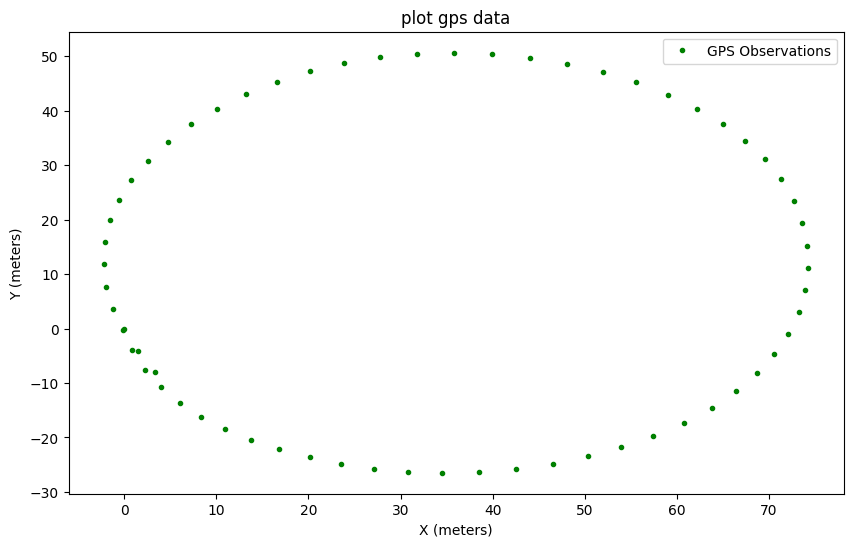

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(gps_data['x'], gps_data['y'], 'g.', label="GPS Observations")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.title("plot gps data")
plt.show()


## **read imu data**

In [ ]:
imu_data = pd.read_csv(imu_path,
                       names = ['timestamp', 'ax', 'ay', "omega"])

imu_data = imu_data.apply(pd.to_numeric,
                           errors='coerce')

imu_data.dropna(inplace=True)
imu_data

data

In [94]:
initial_state = np.array([
    gps_data['x'].iloc[0],
    gps_data['y'].iloc[0],
    0, 
    0, 
    0
])

initial_state

array([0., 0., 0., 0., 0.])

In [ ]:
R = np.diag([100, 100, 16, 16, 0.25])  # Process noise
Q = np.diag([100, 100])  # Observation noise

In [ ]:
X_est = initial_state
P = np.eye(5) * 100

In [ ]:
def state_transition(X_prev, ax, ay, omega, dt):
    ax = ax * np.cos(omega) - ay * np.sin(omega)
    ay = ax * np.sin(omega) + ay * np.cos(omega)
    
    x, y, vx, vy, psi = X_prev
    x += vx * dt + 0.5 * ax * dt**2
    y += vy * dt + 0.5 * ay * dt**2
    vx += ax * dt
    vy += ay * dt
    psi += omega * dt
    return np.array([x, y, vx, vy, psi])

In [157]:
def jacobian_F(X, ax, ay, omega_z, dt):
    F = np.eye(5)
    F[0, 2] = F[1, 3] = dt
    F[0, 4] = F[2, 4] = - ((ax * np.sin(omega_z)) + (ay * np.cos(omega_z)))
    F[1, 4] = F[3, 4] = (ax * np.cos(omega_z)) - (ay * np.sin(omega_z))
    return F

In [158]:
estimates = []

In [ ]:
R = np.diag([100, 100, 16, 16, 0.25])  # Process noise
Q = np.diag([200, 200])  # Observation noise

X_est = initial_state
prob = [50,50,3,3,1]
P = np.eye(5) * prob 

estimates = []
gps_index = 0

[[50.  0.  0.  0.  0.]
 [ 0. 50.  0.  0.  0.]
 [ 0.  0.  3.  0.  0.]
 [ 0.  0.  0.  3.  0.]
 [ 0.  0.  0.  0.  1.]]


In [175]:
estimates = []
gps_index = 0
eclips = []

In [173]:
def observation_model(X):
    return X[:2] 

In [ ]:
for i, imu_row in imu_data.iterrows():
    dt = (imu_row['timestamp'] - imu_data['timestamp'].iloc[i - 1]) * 1e-9 if i > 0 else 0
    ax, ay, omega_z = imu_row['ax'], imu_row['ay'], imu_row['omega']

    X_pred = state_transition(X_est, ax, ay, omega_z, dt)
    F = jacobian_F(X_est, ax, ay, omega_z, dt)
    P = F @ P @ F.T + R

    eclips.append([np.sqrt(P[0][0]),np.sqrt(P[0][1])])

    if gps_index < len(gps_data) and gps_data['timestamp'].iloc[gps_index] <= imu_row['timestamp']:
        z = np.array([gps_data['x'].iloc[gps_index], gps_data['y'].iloc[gps_index]])
        H = np.array([[1, 0, 0, 0, 0], [0, 1, 0, 0, 0]])
        S = H @ P @ H.T + Q
        K = P @ H.T @ np.linalg.inv(S)
        X_est = X_pred + K @ (z - observation_model(X_pred))
        P = (np.eye(5) - K @ H) @ P
        gps_index += 1
    else:
        X_est = X_pred

    estimates.append(X_est)

estimates = np.array(estimates)

141.24439974213564 130.5036488649835
16.642608688450483 10.260318185423182
24.947918783786072 20.036455133075904
34.32442360048052 30.551404727098614
16.183578684915467 9.658519499118064
23.64760184446122 17.832512045920808
31.862964510287565 26.93269633143553
40.88748689065301 36.77244664110569
50.61354782399029 47.41903840219737
61.07254120665544 58.67590120445495
72.13388757450564 70.65811878629378
83.84810255211879 83.182304660001
96.04694788905134 96.30856228924212
108.82419384856932 109.87954397444464
122.1235393363395 124.11015129349107
135.87616569241536 138.68847584432646
150.13501915087954 153.9037210325495
164.8557238688668 169.4516003509639
179.9700872624709 185.37660867466332
195.48906626664865 201.83644421746868
211.42313039285523 218.63907240518904
227.72300476090183 235.72491611443192
244.31184039827542 253.32938554448998
261.2995399915904 271.2064393794234
278.642141990548 289.38473282039246
296.36779091581866 307.9438687224893
314.3356221593811 326.9433660905388
18.09

In [179]:
eclips

[[141.24439974213564, 130.5036488649835],
 [16.642608688450483, 10.260318185423182],
 [24.947918783786072, 20.036455133075904],
 [34.32442360048052, 30.551404727098614],
 [16.183578684915467, 9.658519499118064],
 [23.64760184446122, 17.832512045920808],
 [31.862964510287565, 26.93269633143553],
 [40.88748689065301, 36.77244664110569],
 [50.61354782399029, 47.41903840219737],
 [61.07254120665544, 58.67590120445495],
 [72.13388757450564, 70.65811878629378],
 [83.84810255211879, 83.182304660001],
 [96.04694788905134, 96.30856228924212],
 [108.82419384856932, 109.87954397444464],
 [122.1235393363395, 124.11015129349107],
 [135.87616569241536, 138.68847584432646],
 [150.13501915087954, 153.9037210325495],
 [164.8557238688668, 169.4516003509639],
 [179.9700872624709, 185.37660867466332],
 [195.48906626664865, 201.83644421746868],
 [211.42313039285523, 218.63907240518904],
 [227.72300476090183, 235.72491611443192],
 [244.31184039827542, 253.32938554448998],
 [261.2995399915904, 271.2064393794

In [ ]:
estimates[0]

array([ 4.86942747e-05, -9.81449056e-05, -1.32128045e+00, -1.41398727e+00,
       -3.29578389e-02])

In [152]:
x = estimates[:, 0]
y = estimates[:, 1]

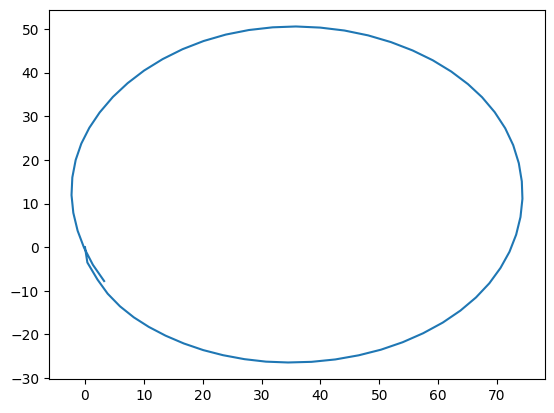

In [163]:
plt.plot(x,y)

In [141]:
x = estimates.T

In [143]:
x[:2]

array([[ 4.86942747e-05,  4.86942747e-05,  4.86942747e-05, ...,
         3.25337080e+00,  3.25337080e+00,  3.25337080e+00],
       [-9.81449056e-05, -9.81449056e-05, -9.81449056e-05, ...,
        -7.76428471e+00, -7.76428471e+00, -7.76428471e+00]])

In [ ]:
plt.plot(x[:2])

In [183]:
x

0.434677223932014

In [193]:
eclips[0]

[141.24439974213564, 130.5036488649835]

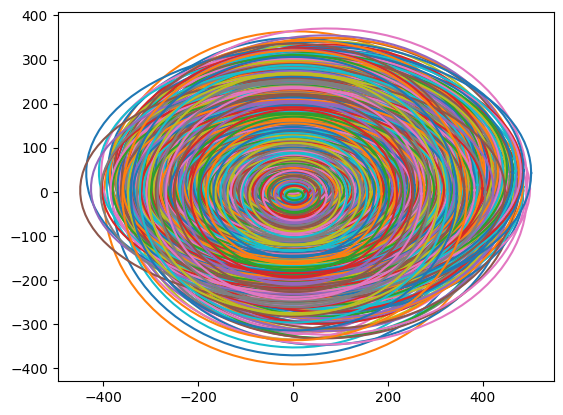

In [194]:
for i in range(1350):
    x = estimates[:, 0][i]
    y = estimates[:, 1][i]

    a = eclips[i][0]
    b = eclips[i][1]

    t = np.linspace(0, 2*np.pi,100)
    plt.plot(x+a*np.cos(t), y+b*np.sin(t))


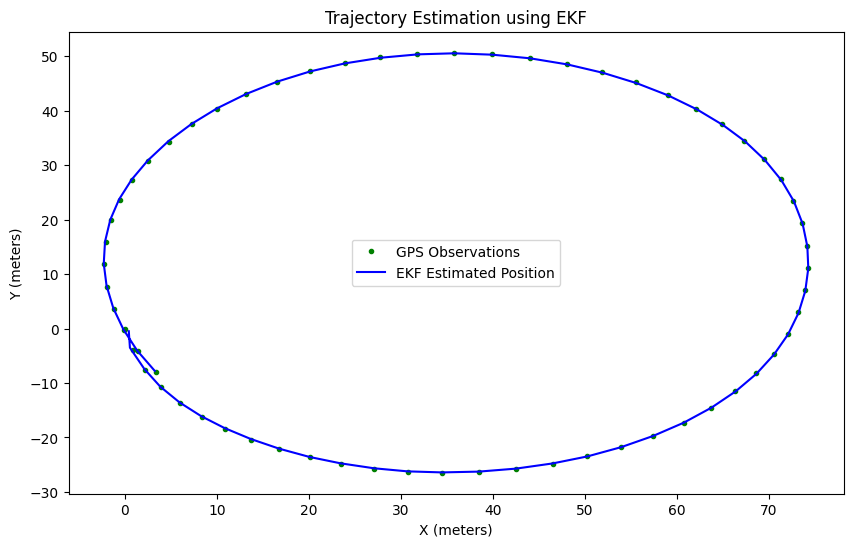

In [185]:
plt.figure(figsize=(10, 6))
plt.plot(gps_data['x'], gps_data['y'], 'g.', label="GPS Observations")
plt.plot(estimates[:, 0], estimates[:, 1], 'b-', label="EKF Estimated Position")
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")
plt.legend()
plt.title("Trajectory Estimation using EKF")
plt.show()
